In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import celltypist
import gc
import anndata
from celltypist import models
import h5py
import scipy.sparse as scs
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from adjustText import adjust_text
import scanpy.external as sce
import multiprocessing
import copy


/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-p

In [3]:
meta_data=pd.read_csv('/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/meta_data_GEO.csv')


In [4]:
adata=sc.read_h5ad("/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/TEA_scRNA.h5ad")
adata=adata.raw.to_adata()

In [5]:
adata.write_h5ad("TEA_scRNA_all.h5ad")

In [5]:
adata_ADT=sc.read_h5ad('ADT.h5ad')
df_ADT=pd.DataFrame(adata_ADT.X)
df_ADT.columns=["ADT_"+i for i in adata_ADT.var_names.tolist()]
df_ADT.index=adata_ADT.obs.index.tolist()

In [6]:
adata_subset=adata[adata_ADT.obs.index]
df_ADT=df_ADT.loc[adata_subset.obs.index.tolist(),]
adata_subset.obs=adata_subset.obs.merge(df_ADT, left_index=True, right_index=True)

In [7]:
adata_subset.raw=adata_subset
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)

In [8]:
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [9]:
%%time
sc.pp.scale(adata_subset)
sc.tl.pca(adata_subset,
          svd_solver='arpack')
sce.pp.harmony_integrate(adata_subset,
                         'batch_id',
                         max_iter_harmony = 20)
sc.pp.neighbors(adata_subset,
                n_neighbors=50,
                use_rep='X_pca_harmony',
                n_pcs=30)

2025-01-16 18:01:22,423 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-01-16 18:02:20,651 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-01-16 18:02:21,832 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2025-01-16 18:03:50,422 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2025-01-16 18:05:28,412 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2025-01-16 18:07:02,225 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2025-01-16 18:08:57,302 - harmonypy - INFO - Iteration 6 of 20
Iteration 6 of 20
2025-01-16 18:09:46,529 - harmonypy - INFO - Iteration 7 of 20
Iteration 7 of 20
2025-01-16 18:10:25,711 - harmonypy - INFO - Iteration 8 of 20
Iteration 8 of 20
2025-01-16 18:10:57,628 - harmonypy - INFO - Converged after 8 iterations
Converged after 8 iterations
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.1

CPU times: user 1h 13min 44s, sys: 9.66 s, total: 1h 13min 53s
Wall time: 12min 23s


In [10]:
%%time
sc.tl.umap(adata_subset,
           min_dist=0.45,
           random_state=0)

CPU times: user 15min 50s, sys: 372 ms, total: 15min 50s
Wall time: 2min 42s


In [11]:
meta_data["cohort"]=[x[0:3] for x in meta_data["subject_id.ch1"] ]

In [12]:
df=adata_subset.obs
df=df.reset_index()
df=df.merge(meta_data, on='pbmc_sample_id',how='left')


In [13]:
df.index=df['barcodes'].tolist()
adata_subset.obs=df

In [14]:
adata_subset.obs.columns

Index(['index', 'barcodes', 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name',
       'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis',
       'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id',
       'rna_cell_uuid', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1',
       'umap_2', 'well_id', 'predicted_doublet', 'doublet_score', 'AIFI_L1',
       'AIFI_L2', 'AIFI_L3', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mito',
       'log1p_total_counts_mito', 'pct_counts_mito', 'ADT_CD194', 'ADT_CD196',
       'ADT_CD294', 'ADT_CD49d', 'ADT_CD278', 'ADT_CD11b', 'ADT_CD11c',
       'ADT_CD127', 'ADT_CD16', 'ADT_CD185', 'ADT_CD25', 'ADT_CD27',
       'ADT_CD38', 'ADT_CD39', 'ADT_CD4', 'ADT_CD56', 'ADT_CD71', 'ADT_CD86',
       'ADT_TCR_Valpha7.2', 'ADT

In [15]:
adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)

... storing 'pbmc_sample_id' as categorical
... storing 'GEO_Accession' as categorical
... storing 'Batch' as categorical
... storing 'combined_sample_id' as categorical
... storing 'cell.type.ch1' as categorical
... storing 'race.ch1' as categorical
... storing 'Sex.ch1' as categorical
... storing 'subject_id.ch1' as categorical
... storing 'cohort' as categorical


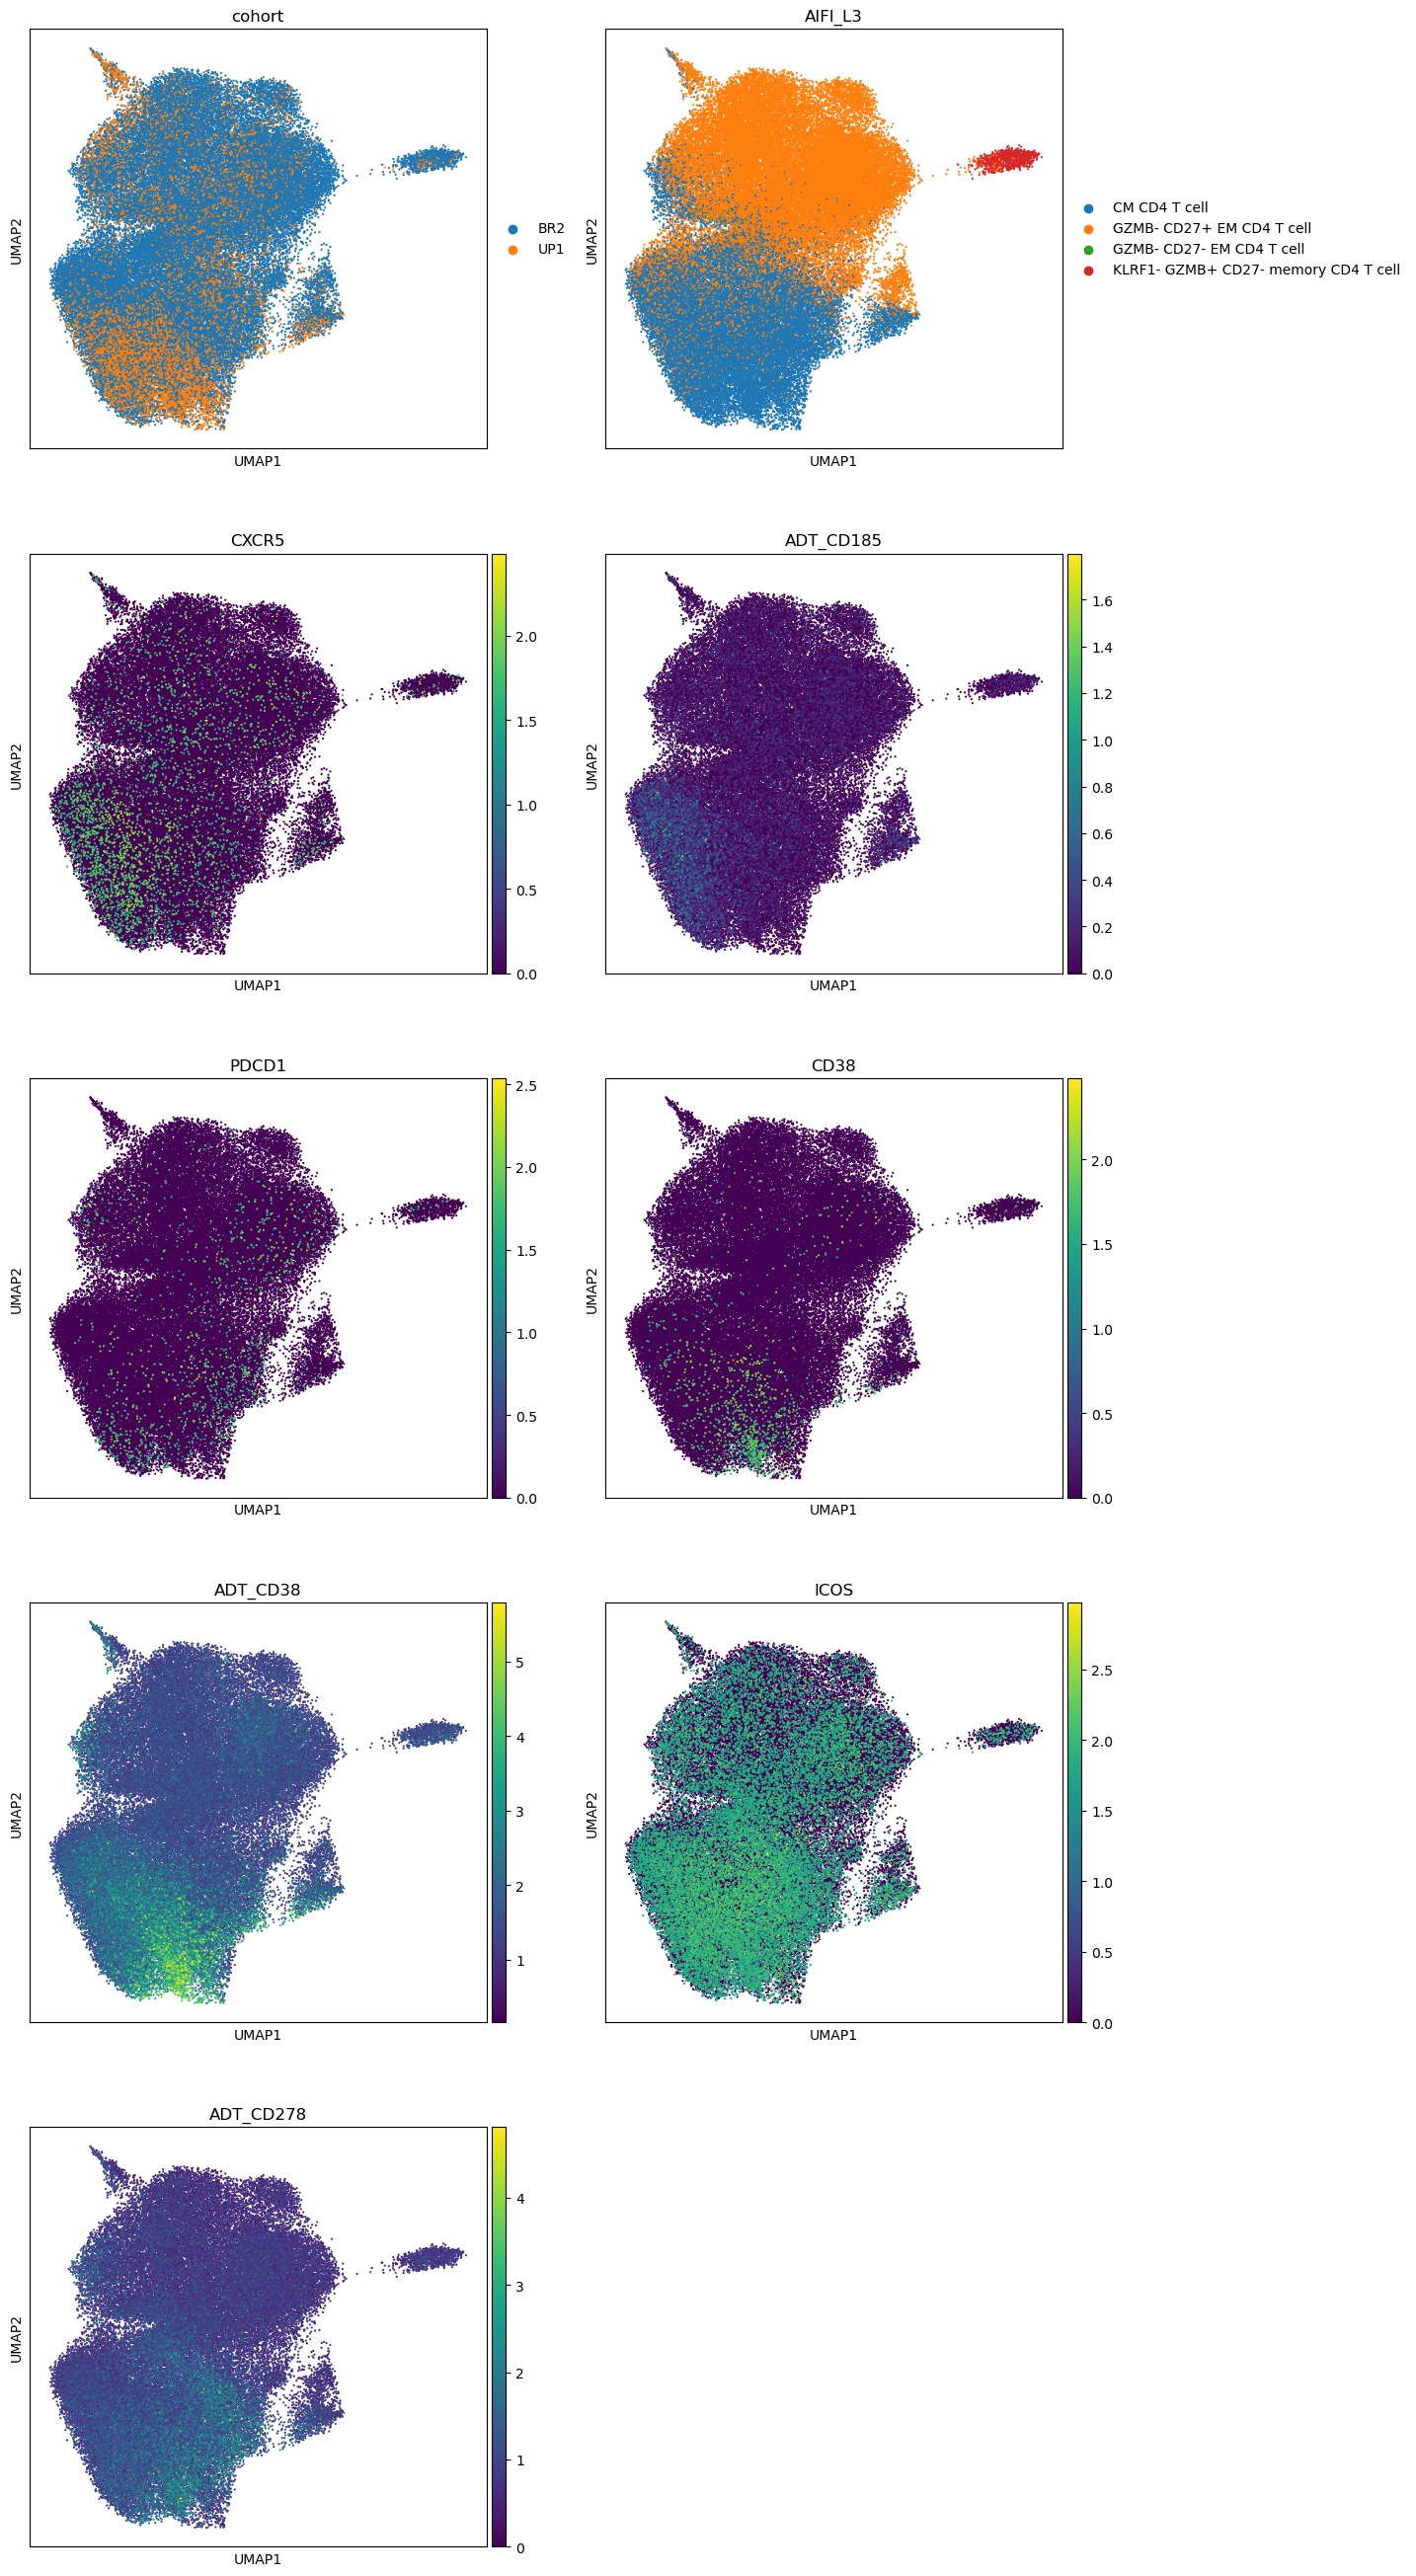

In [16]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["cohort",'AIFI_L3',
                         "CXCR5","ADT_CD185",
                         "PDCD1",#"ADT_CD279",
                         "CD38","ADT_CD38",
                         "ICOS","ADT_CD278"],size=10,use_raw=False,ncols=2)


In [17]:
def run_leiden_and_extract(args):
    adata, resolution, key_added = args
    adata_copy = copy.deepcopy(adata)
    sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added)
    return key_added, adata_copy.obs[key_added].copy()  

tasks = [
    (adata_subset, 0.5, "rna_leiden_res_0.5"),
    (adata_subset, 1, "rna_leiden_res_1"),
    (adata_subset, 1.25, "rna_leiden_res_1.25"),
    (adata_subset, 1.5, "rna_leiden_res_1.5"),
    (adata_subset, 2, "rna_leiden_res_2"),
    (adata_subset, 2.5, "rna_leiden_res_2.5")
]

if __name__ == "__main__":
    with multiprocessing.Pool(processes=len(tasks)) as pool:
        results = pool.map(run_leiden_and_extract, tasks)

    for key_added, clustering_info in results:
        adata_subset.obs[key_added] = clustering_info

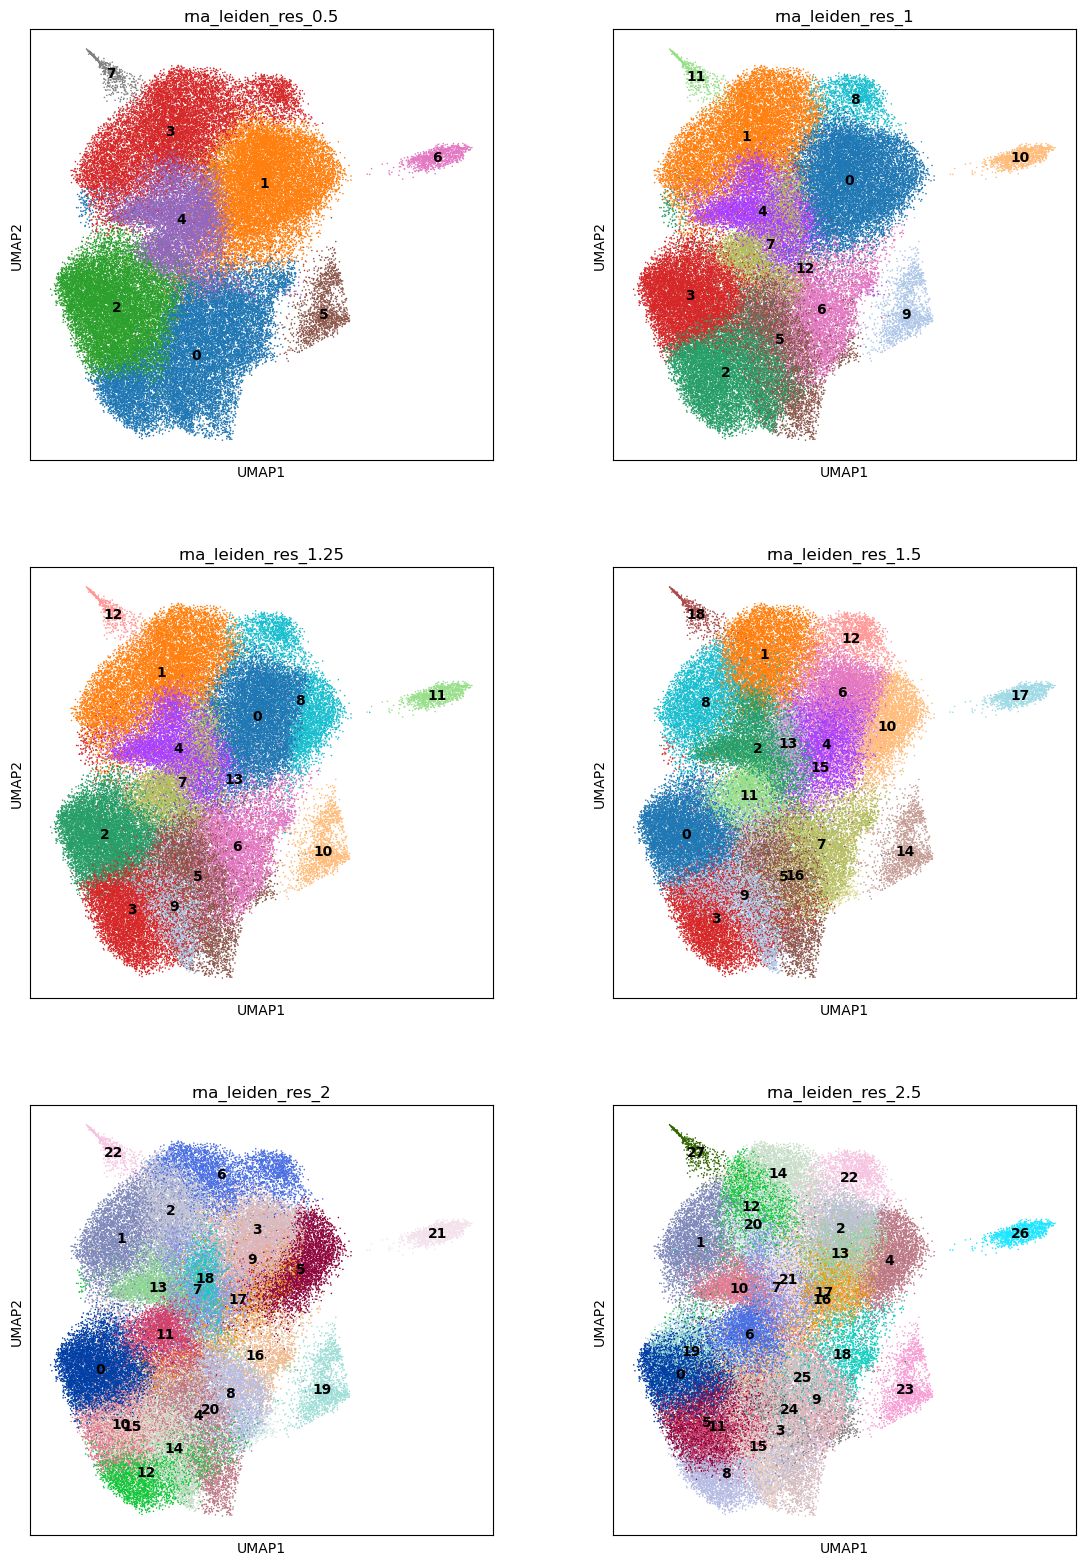

In [18]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["rna_leiden_res_0.5","rna_leiden_res_1",
                         "rna_leiden_res_1.25","rna_leiden_res_1.5",
                         "rna_leiden_res_2","rna_leiden_res_2.5"],size=5,
           legend_loc='on data',use_raw=False,ncols=2)


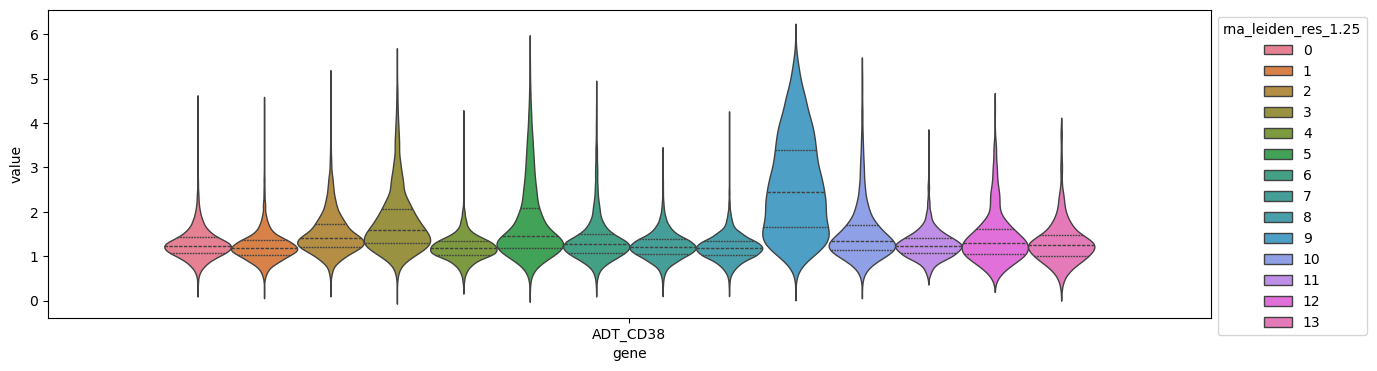

In [19]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 4]
df = sc.get.obs_df(adata_subset, ['ADT_CD38','rna_leiden_res_1.25'])
df = df.set_index('rna_leiden_res_1.25').stack().reset_index()
df.columns = ['rna_leiden_res_1.25', 'gene', 'value']
ax=sns.violinplot(data=df[df['value']>0], x='gene', y='value', hue="rna_leiden_res_1.25",
                 inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

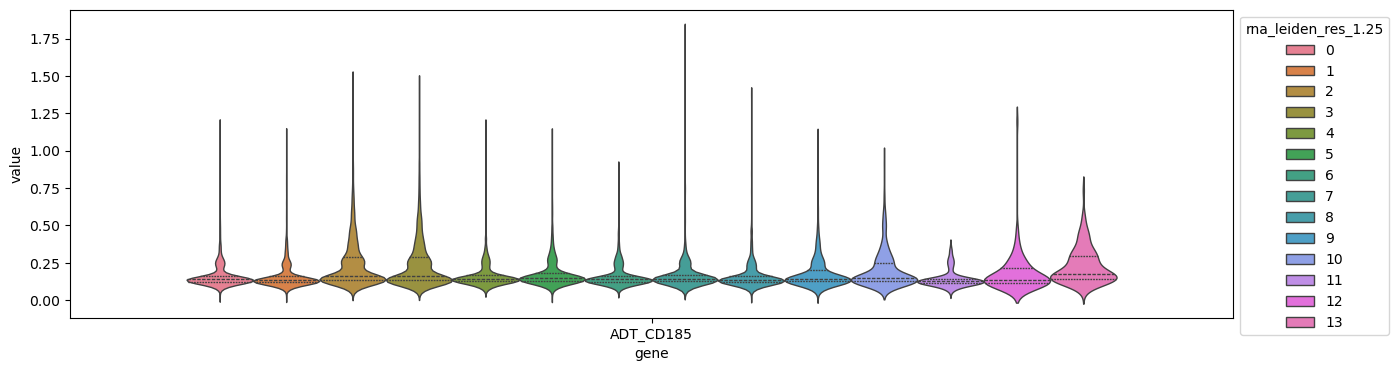

In [20]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 4]
df = sc.get.obs_df(adata_subset, ['ADT_CD185','rna_leiden_res_1.25'])
df = df.set_index('rna_leiden_res_1.25').stack().reset_index()
df.columns = ['rna_leiden_res_1.25', 'gene', 'value']
ax=sns.violinplot(data=df[df['value']>0], x='gene', y='value', hue="rna_leiden_res_1.25",
                 inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [21]:
df_RNA_Exp=pd.DataFrame(adata_subset.X.todense())
df_RNA_Exp.columns= adata_subset.var_names.tolist()
df_RNA_Exp.index=adata_subset.obs.index.tolist()

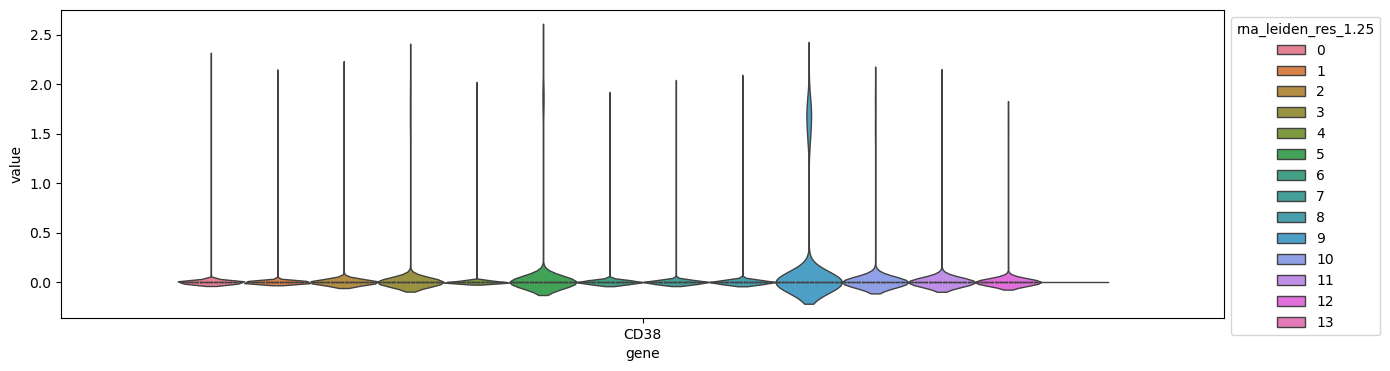

In [22]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 4]
df=adata_subset.obs
df['value']=df_RNA_Exp['CD38'].tolist()
df['gene']="CD38"
ax=sns.violinplot(data=df, x='gene', y='value', hue="rna_leiden_res_1.25",
                 inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

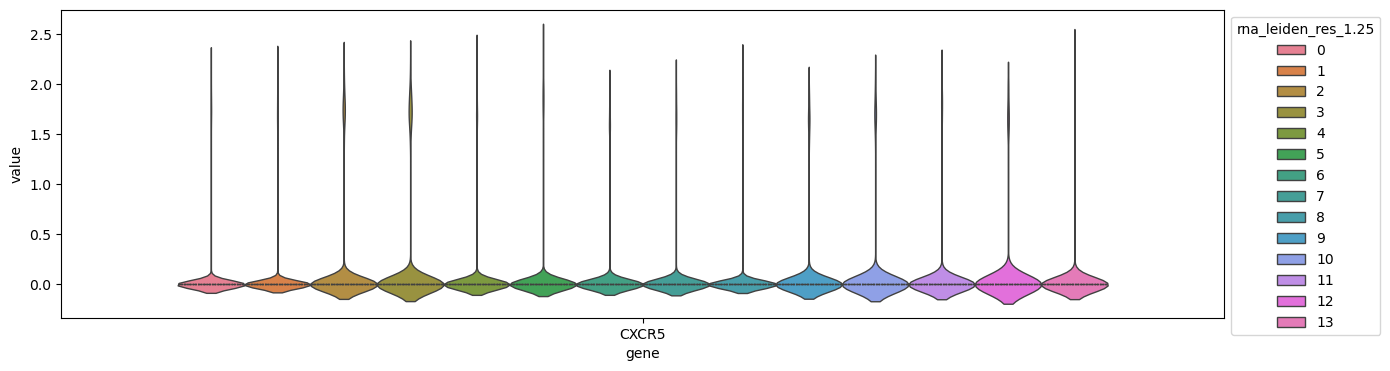

In [23]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 4]
df=adata_subset.obs
df['value']=df_RNA_Exp['CXCR5'].tolist()
df['gene']="CXCR5"
ax=sns.violinplot(data=df, x='gene', y='value', hue="rna_leiden_res_1.25",
                 inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
adata_subset

In [24]:
conditions = [
    adata_subset.obs['rna_leiden_res_1.25'].isin(['9']),
    adata_subset.obs['rna_leiden_res_1.25'].isin(['2','3']),
]

choices = ['CXCR5+CD38+ICOS+ TFH', 'CXCR5+CD38-ICOS- TFH']

# Mutate column 'C' based on conditions
adata_subset.obs['celltype_new'] = np.select(conditions, choices, default=adata_subset.obs['AIFI_L3'])

In [25]:
adata_subset.write_h5ad("Tfh_Clusterd.h5ad")

... storing 'gene' as categorical
... storing 'celltype_new' as categorical


In [4]:
adata=sc.read_h5ad("Tfh_Clusterd.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 73154 × 36601
    obs: 'index', 'barcodes', 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'rna_cell_uuid', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ADT_CD194', 'ADT_CD196', 'ADT_CD294', 'ADT_CD49d', 'ADT_CD278', 'ADT_CD11b', 'ADT_CD11c', 'ADT_CD127', 'ADT_CD16', 'ADT_CD185', 'ADT_CD25', 'ADT_CD27', 'ADT_CD38', 'ADT_CD39', 'ADT_CD4', 'ADT_CD56', 'ADT_CD71', 'ADT_CD86', 'ADT_TCR_Valpha7.2', 'ADT_CD103', 'ADT_CD57', 'ADT_CD69', 'ADT_

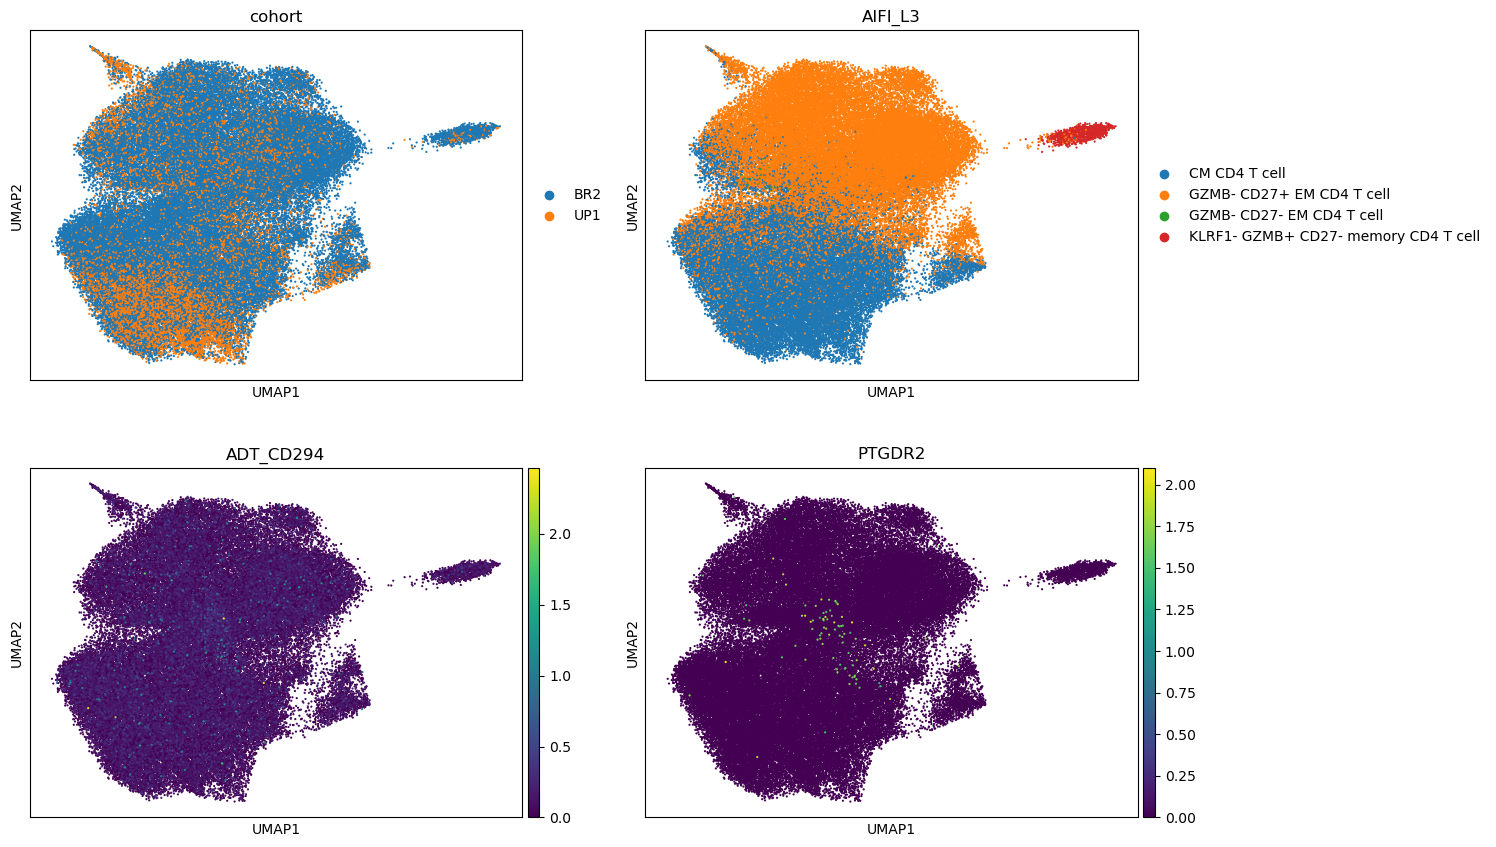

In [11]:
sc.pl.umap(adata, color=["cohort",'AIFI_L3',
                        "ADT_CD294","PTGDR2"
                 ],size=10,use_raw=False,ncols=2)